# Customer Churn Prediction for Interconnect Telecom

In this project, we work with data from Interconnect, a telecom operator aiming to reduce customer churn by identifying clients at risk of leaving. The marketing team at Interconnect has collected a rich dataset containing customer demographics, contract types, phone and internet services, and payment methods.

The goal is to develop a predictive model that can accurately forecast customer churn. If a client is predicted to be at risk, the company plans to proactively offer them promotional codes or tailored service plans to encourage retention.

Interconnect offers two primary services:

Landline communication, allowing multi-line connections.
Internet service, delivered via DSL or fiber optic cable.
Additional services include antivirus protection, cloud backup, dedicated tech support, and streaming options. Customers can choose from monthly plans or commit to 1- or 2-year contracts, and they have various billing and payment options.

The data provided comes from multiple sources and includes:

contract.csv: Contract details (e.g., tenure, type, charges)
personal.csv: Customer demographics
internet.csv: Internet-related services
phone.csv: Telephone service usage
Each client is uniquely identified by a customerID, which allows for merging the data into a comprehensive customer profile. The contract data is current as of February 1, 2020.

The outcome of this project will help Interconnect’s marketing and customer service teams target at-risk clients, optimize retention strategies, and ultimately reduce revenue loss due to churn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
import time

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc


In [2]:
#contract = pd.read_csv('/datasets/final_provider/contract.csv')
#internet = pd.read_csv('/datasets/final_provider/internet.csv')
#personal = pd.read_csv('/datasets/final_provider/personal.csv')
#phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
contract = pd.read_csv('/Users/keithrobinson/Desktop/TripleTen/Projects/project17/contract.csv')
internet = pd.read_csv('/Users/keithrobinson/Desktop/TripleTen/Projects/project17/internet.csv')
personal = pd.read_csv('/Users/keithrobinson/Desktop/TripleTen/Projects/project17/personal.csv')
phone = pd.read_csv('/Users/keithrobinson/Desktop/TripleTen/Projects/project17/phone.csv')


## Brief analysis to develop work plan

### `contract`

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


There looks to be 7,043 entries in this dataframe. No explicit missing values.

For this dataframe, I want to convert the `BeginDate` to datetime format and `TotalCharges` to float if possible.

Insight on some meaningful columns:
* `customerID`: indicates that there are 7,043 customers
* `EndDate`: this is our target. it contains two different types of data (datetime, string). I will address this later in the project with some feature engineering
* `Type`: crucial column in my eyes. Month-to-month customers can leave at any moment, whereas those in 1-year or 2-year contracts will have a harder time churning. So harder to predict with the month-to-month customers

### `internet`

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


There are 5,517 entries on the `internet` dataframe. No explicit missing values. The datatypes at first glance look fine to me. I may OneHotEncode or LabelEncode to pass these through a machine learning algorithm later. 

Insights on some meaningful columns:
* `customerID`: The count on this dataframe is about 1,500 less than that of the contracts dataframe telling me that about 1,500 customers don't have internet service. So when I merge these tables together there will be about 1,500 missing values. 

I'm putting a note for myself for later reference to NOT drop these values because they are still customers, but either fill with 'np.nan', '0' or feature engineer a new column specifying if they have internet service or not.

### `personal`

In [8]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


There are 7,043 entries in this table, the same exact count as the `contract` dataframe. This shows me that every customer has his/her demographic information and there are no explicit missing values. It doesn not look that any of the columns data needs to be converted.

Insight on some meaningful columns:
* `Partner` and `Dependents`: I would like to check whether customers who have partners or dependents are less likely to leave the service.

### `phone`

In [10]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [11]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


There are 6,361 entries in the `phone` dataframe. This tells me that there are about 675 customers who don't have phone service. There are no explicit missing values. 

### `merged_df`

I want to merge these dataframes together to see if I can get more information on the users and why they may churn.

In [12]:
dfs = [contract, internet, personal, phone]
# Merge all dataframes on 'customerID'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='customerID', how='outer'), dfs)
# Display the merged dataframe
merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.4,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No


In [13]:
print(merged_df['EndDate'].max())

No


## Brief Recap

There are 7043 customers containing services and demographic information. Some of these customers don't use certain services, e.g. having multiple lines or internet services.

There are no explicit missing values, but once I merged all four tables together based on `customerID` there are about 2000 rows with missing values.

Churn is the main thing we're concerned about. In looking at the current churn rate, churned customers account for about 27% of this dataset. So being that the data is imbalanced, I have to take that into account when creating my model for later.

## Proposed Work Plan

According to the criteria of this project, I have determined this is a classification project. The goal of this project is to predict whether the customer will churn or not.

Based on the information, I will design the working plan which will cover the following steps: 

1. Preprocessing

In this step I will investigate all columns in each dataframe and apply appropriate methods on each of them if necessary.

* Replace all column names with snake case format
* Convert columns to appropriate data types
* Fill or drop any missing values

2. EDA

* Check data distributions and outliers
* Check correlation between target and features
* Analyze some of the categorical features

3. Feature Engineering

* The `EndDate` column I can't completely convert because I will lose critical information. I will create a new column called `churn` that will give me a binary option on whether the customer churned or not.
* I want to create a feature telling me whether the customer has extra services.
* I'll have to one-hot encode or label encode some of the features since they are not all numerical figures.
* I'll have to scale the data
* If we have redundant features, I will remove those.
* Finally I will split the data into training, testing and validation sets.

4. Train Models

For this portion, since I know it's a classification problem I will start with the simplest model (Logistic Regression) and see where we measure on that. If the model underfits I will then add complexity first by picking a more complex model (Bagging or Boosting) and then I will tune hyperparameters and perform k-fold cross validation to select the best models and hyperparameters.

5. Test Models

Once I find a model that works well on the validation set, I will then try the model out on the test set and I will evaluate AUC-ROC on that. 

6. Conclusion

I will state my conclusion and prepare for next steps.

# Preprocessing

## Renaming columns

In [14]:
merged_df = merged_df.rename(columns={'customerID': 'customer_id', 'BeginDate': 'begin_date',  'EndDate': 'end_date', 'Type': 'type', 'PaperlessBilling':'paperless_billing', 'PaymentMethod':'payment_method',
                   'MonthlyCharges': 'monthly_charges', 'TotalCharges':'total_charges', 'InternetService':'internet_service', 'OnlineSecurity':'online_security', 'OnlineBackup':'online_backup',
                   'DeviceProtection':'device_protection', 'TechSupport': 'tech_support', 'StreamingTV': 'streaming_TV', 'StreamingMovies': 'streaming_movies', 'SeniorCitizen': 'senior_citizen',
                   'Partner': 'partner', 'Dependents': 'dependents', 'MultipleLines': 'multiple_lines'})

## Addressing missing values

In [15]:
merged_df.isnull().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_TV         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
dtype: int64

We have missing values from both the internet dataframe and phone (`MultipleLines`) dataframe which tells me that there are customers who don't have internet services or don't have multiple lines if they have phone service.

I want to look at the distribution of beginning service dates is different across people that have all services or are missing internet/not having multiple lines.

In [16]:
merged_df['begin_date'] = pd.to_datetime(merged_df['begin_date']).dt.normalize()

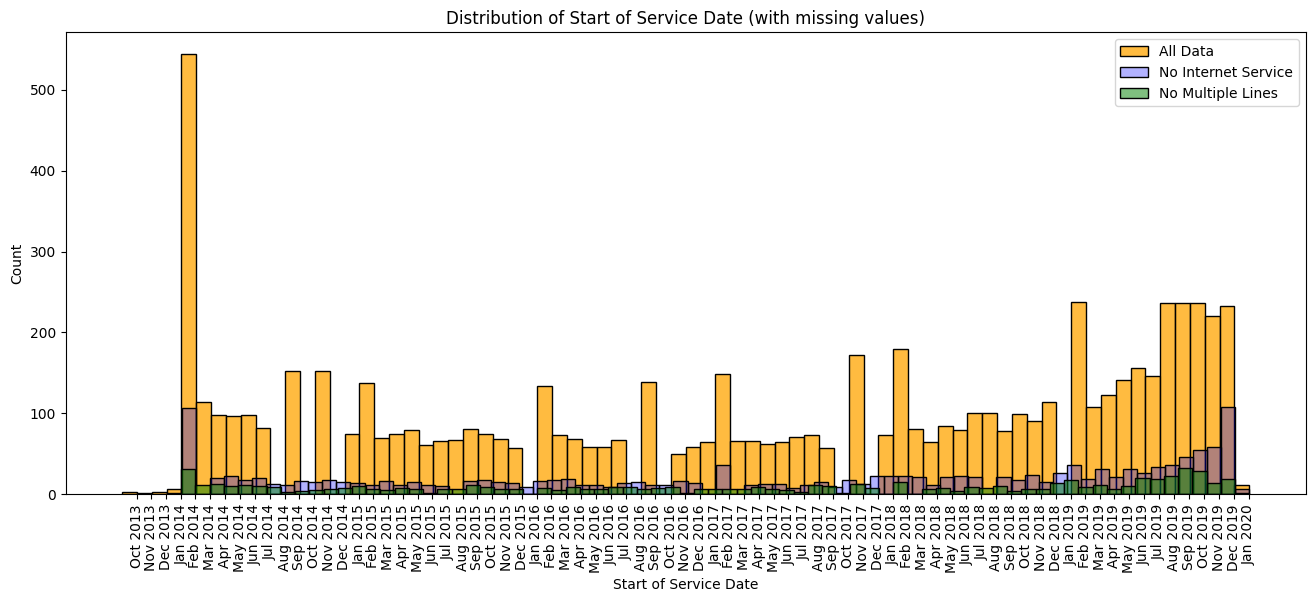

In [17]:
begin_date_range = pd.date_range(start=merged_df['begin_date'].min(), end=merged_df['begin_date'].max(), freq='ME')
plt.figure(figsize=(16, 6))
sns.histplot(data=merged_df, x='begin_date', bins=len(begin_date_range), color='orange', label='All Data')
sns.histplot(data=merged_df[merged_df['internet_service'].isnull()], x='begin_date', bins=len(begin_date_range), color='blue', label='No Internet Service', alpha=0.3)
sns.histplot(data=merged_df[merged_df['multiple_lines'].isnull()], x='begin_date', bins=len(begin_date_range), color='green', label='No Multiple Lines', alpha=.5)
plt.xlabel('Start of Service Date')
plt.ylabel('Count')
plt.title('Distribution of Start of Service Date (with missing values)')
plt.xticks(begin_date_range, [date.strftime('%b %Y') for date in begin_date_range], rotation=90)
plt.legend()
plt.show()

When analyzing the distribution, the frequencies across all of the data, (no internet services and not having multiple lines), lines up with each other. So I'm going to confidently say it's the missing values aren't from a particular time slot.

For all columns except `internet_service`, I'm going to assume if there is a missing value that it is a 'No'. No because they don't have those internet services or multiple lines, so I'm going to fill those null values with 'No'.

`internet_service` is a little trickier. We have either 'fiber optic' or 'DSL' but if the customer doesn't have internet services then that needs to be displayed as well. I will fill these missing values with 'None'. Later on when I start modeling I will need to encode.

In [18]:
merged_df.fillna({'online_security': 'No',
                  'online_backup': 'No',
                  'device_protection': 'No',
                  'tech_support': 'No',
                  'streaming_TV': 'No',
                  'streaming_movies': 'No',
                  'multiple_lines': 'No',
                  'internet_service': 'None'}, inplace=True)

In [19]:
merged_df.isnull().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_TV         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

## Converting data

I am changing a number of columns from 'Yes'/'No' to 1/0. I will also assign gender a 1 for Male and 0 for Female.

I changed `total_charges` to float values. There missing values so I forced those missing values into NaN's.

In [20]:
merged_df['total_charges'] = pd.to_numeric(merged_df['total_charges'], errors='coerce')

In [21]:
cols_to_convert = ['paperless_billing', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_TV', 'streaming_movies', 'partner', 'dependents', 'multiple_lines', 'gender']
merged_df[cols_to_convert] = merged_df[cols_to_convert].replace({'Yes': 1, 'No': 0})
merged_df = merged_df.infer_objects(copy=False)


/var/folders/2c/tfkhfg6d5jj1g3ttv18s3t5r0000gn/T/ipykernel_38986/3248174939.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df[cols_to_convert] = merged_df[cols_to_convert].replace({'Yes': 1, 'No': 0})


In [22]:
merged_df['gender'] = merged_df['gender'].replace({'Male': 1, 'Female': 0})


/var/folders/2c/tfkhfg6d5jj1g3ttv18s3t5r0000gn/T/ipykernel_38986/748031130.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['gender'] = merged_df['gender'].replace({'Male': 1, 'Female': 0})


In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   int64         
 10  online_backup      7043 non-null   int64         
 11  device_protection  7043 non-null   int64         
 12  tech_support       7043 non-null   int64         
 13  streaming_TV       7043 non-null   int64         
 14  streamin

In [24]:
merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,0002-ORFBO,2019-05-01,No,One year,1,Mailed check,65.6,593.30,DSL,0,1,0,1,1,0,0,0,1,1,0
1,0003-MKNFE,2019-05-01,No,Month-to-month,0,Mailed check,59.9,542.40,DSL,0,0,0,0,0,1,1,0,0,0,1
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,1,Electronic check,73.9,280.85,Fiber optic,0,0,1,0,0,0,1,0,0,0,0
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,1,Electronic check,98.0,1237.85,Fiber optic,0,1,1,0,1,1,1,1,1,0,0
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,83.9,267.40,Fiber optic,0,0,0,1,1,0,0,1,1,0,0


# EDA

## Modifying the Target (`end_date`)

I want to change the `end_date` column to datetime. I will convert the 'No's to a dummy value '2025-05-22 00:00:00' so that I can it is easy to manipulate the column later in my analysis.

In [25]:
merged_df.loc[merged_df['end_date'] == 'No', 'end_date'] = '2025-05-22 00:00:00'
merged_df['end_date'] = pd.to_datetime(merged_df['end_date'])

In [26]:
merged_df['end_date'].unique()

<DatetimeArray>
['2025-05-22 00:00:00', '2020-01-01 00:00:00', '2019-12-01 00:00:00',
 '2019-11-01 00:00:00', '2019-10-01 00:00:00']
Length: 5, dtype: datetime64[ns]

Looking at the unique values in `end_date`, customers have only churned in the last 4 months of this dataset (Oct 2019, Nov 2019, Dec 2019 and Jan 2020).

In [27]:
merged_df['end_date'].value_counts()

end_date
2025-05-22    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: count, dtype: int64

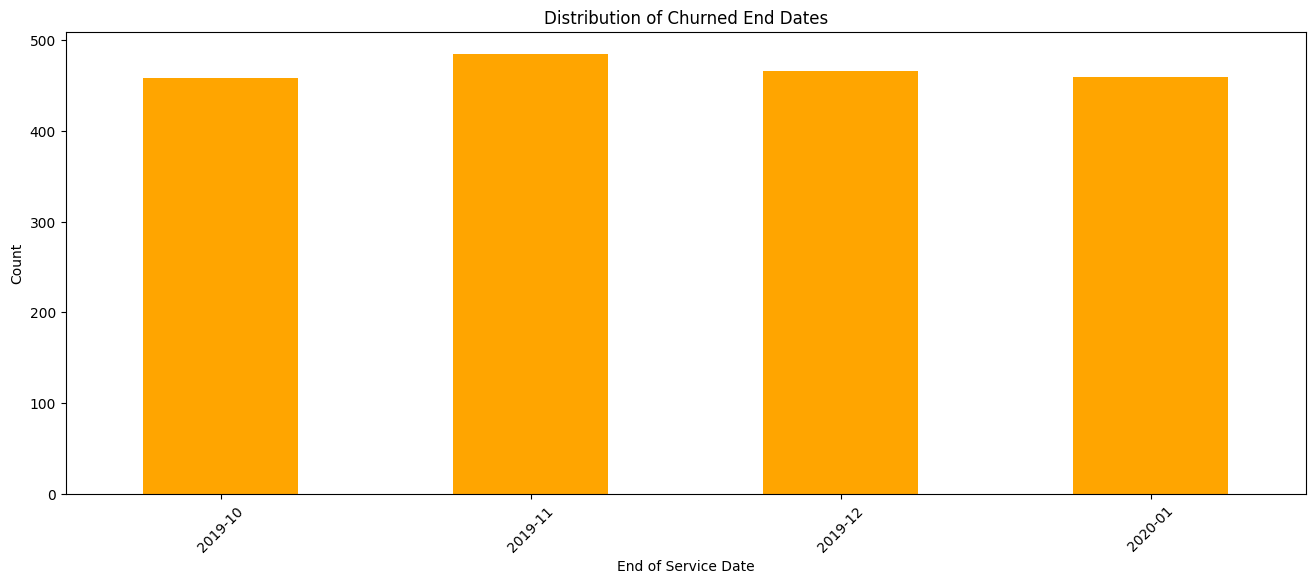

In [28]:
churned = merged_df[merged_df['end_date'] != '2025-05-22 00:00:00']
end_date_counts = churned['end_date'].dt.to_period('M').value_counts().sort_index()
plt.figure(figsize=(16, 6))
end_date_counts.plot(kind='bar', color='orange')
plt.xlabel('End of Service Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Distribution of Churned End Dates')
plt.show()

And it seems to be above 450ish customers each month that they're losing.

## Balance of Target Variable

I'm going to create a simple [1, 0] binary feature called 'churn' based on if a customer has churned or not in this dataframe. 1 = churn, 0 = still a customer.

In [29]:
merged_df['churn'] = np.where(merged_df['end_date'] == '2025-05-22 00:00:00', 0, 1)
merged_df['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

In [30]:
churn_count = merged_df['churn'].sum()
churn_rate = (churn_count / merged_df.shape[0]) * 100
print(f"Churn Count: {churn_rate:.2f}%")

Churn Count: 26.54%


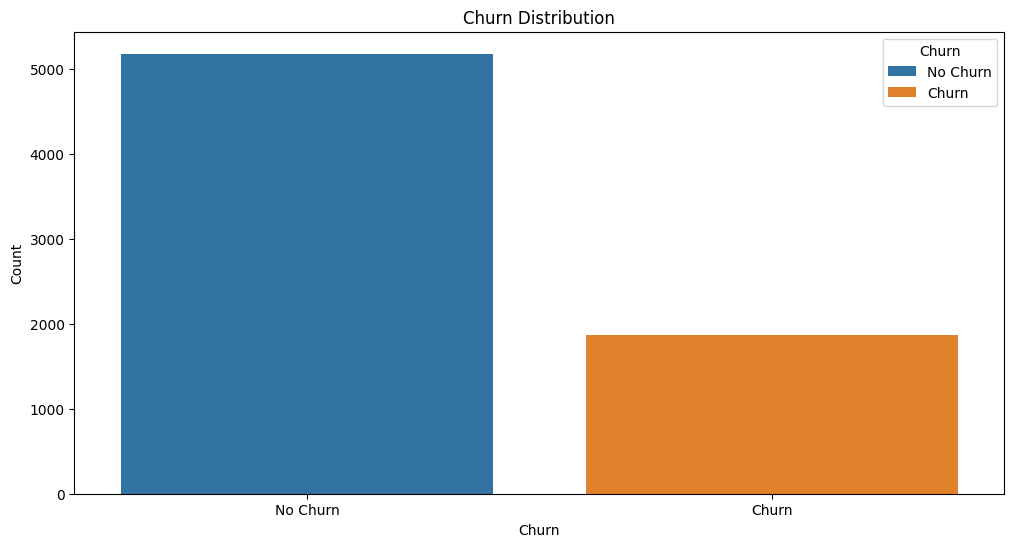

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_df, x='churn', hue='churn')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right', labels=['No Churn', 'Churn'])
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

 The dataset appears to be imbalanced. Accuracy may not be the best measure for our model. I will rely on F1 Score which is a combination of Recall and Precision.

### Extract time information from the target column

This target column is unique in a sense that it had a mix of strings and datetime characters. Earlier I changed the 'No' to an arbitrary datetime value of '2020-02-01 00:00:00', so that I don't have any string values. I will now create a new column and call it `service_months`.

This column might cause data leakage since it will be correlated with the `begin_date` column, therefore I will not use it in training, but only for analyzing the data.

In [32]:
print(merged_df['begin_date'].min())
print(merged_df['begin_date'].max())

2013-10-01 00:00:00
2020-02-01 00:00:00


In [33]:
print(merged_df['end_date'].min())
print(merged_df['end_date'].max())
print(merged_df['end_date'].drop_duplicates().nlargest(5))

2019-10-01 00:00:00
2025-05-22 00:00:00
0    2025-05-22
2    2020-01-01
4    2019-12-01
19   2019-11-01
63   2019-10-01
Name: end_date, dtype: datetime64[ns]


The time between the lowest `begin_date` and the highest `end_date` is 75 months. The arbitrary date added to show they're still in contract was the 76th month.

In [34]:
merged_df['service_months'] = merged_df['end_date'].dt.to_period('M').astype(int) - merged_df['begin_date'].dt.to_period('M').astype(int)
merged_df['service_months']

0        72
1        72
2         4
3        13
4         3
       ... 
7038     76
7039     22
7040     65
7041    130
7042    126
Name: service_months, Length: 7043, dtype: int64

### `service_months` distribution

In [35]:
merged_df['service_months'].value_counts()

service_months
1      380
135    356
64     237
134    164
65     124
      ... 
59       8
45       6
60       6
44       6
62       5
Name: count, Length: 135, dtype: int64

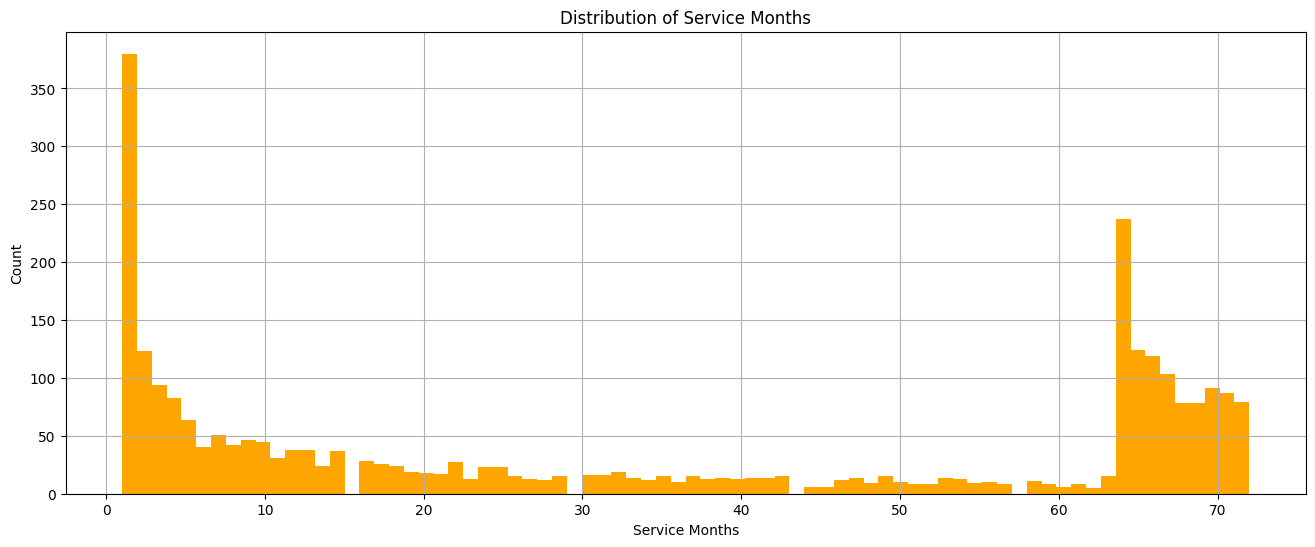

In [36]:
merged_df[~(merged_df['service_months'] > 72)]['service_months'].hist(bins=76, color='orange', figsize=(16, 6))
plt.xlabel('Service Months')
plt.ylabel('Count')
plt.title('Distribution of Service Months')
plt.show()


This distribution shows some long time clients but then also clients who haven't stayed or been with the company very long.

Is there a loyalty rewards program that can be implemented?

In [37]:
# Filter churned customers
churned_customers = merged_df[merged_df['churn'] == 1]

# Filter churned customers with service less than or equal to 6 months
churned_customers_6_months = churned_customers[churned_customers['service_months'] <= 6]

In [38]:
print(f"There are {len(churned_customers_6_months)} churned customers whose service months are less than or equal to 6 months. This makes up {len(churned_customers_6_months) / len(churned):.2%} of all of the churned customers.")

There are 784 churned customers whose service months are less than or equal to 6 months. This makes up 41.95% of all of the churned customers.


I'm going to split the dataframe into two dataframes: 
- 1 for churn
- 1 for customers who have stayed

In [39]:
stay_df = merged_df[merged_df['churn'] == 0]
churned_df = merged_df[merged_df['churn'] == 1]

### `monthly_charges` and `total_charges`

There are two numeric columns that have information pertaining to pricing. I will now examine those columns.

I want to pull statistical information for customers that churned, stay and the original. I will set that up now.

In [40]:
original_mo = merged_df['monthly_charges']
original_total = merged_df['total_charges']

churned_mo = churned_df['monthly_charges']
churned_total = churned_df['total_charges']

stay_mo = stay_df['monthly_charges']
stay_total = stay_df['total_charges']

charges_df = pd.DataFrame({
    'original_monthly': original_mo,
    'original_total': original_total,
    'churned_monthly': churned_mo,
    'churned_total': churned_total,
    'stay_monthly': stay_mo,
    'stay_total': stay_total
})

charges_df.describe()

,original_monthly,original_total,churned_monthly,churned_total,stay_monthly,stay_total
count,7043.000000,7032.000000,1869.000000,1869.000000,5174.000000,5163.000000
mean,64.761692,2283.300441,74.441332,1531.796094,61.265124,2555.344141
std,30.090047,2266.771362,24.666053,1890.822994,31.092648,2329.456984
min,18.250000,18.800000,18.850000,18.850000,18.250000,18.800000
25%,35.500000,401.450000,56.150000,134.500000,25.100000,577.825000
50%,70.350000,1397.475000,79.650000,703.550000,64.425000,1683.600000
75%,89.850000,3794.737500,94.200000,2331.300000,88.400000,4264.125000
max,118.750000,8684.800000,118.350000,8684.800000,118.750000,8672.450000


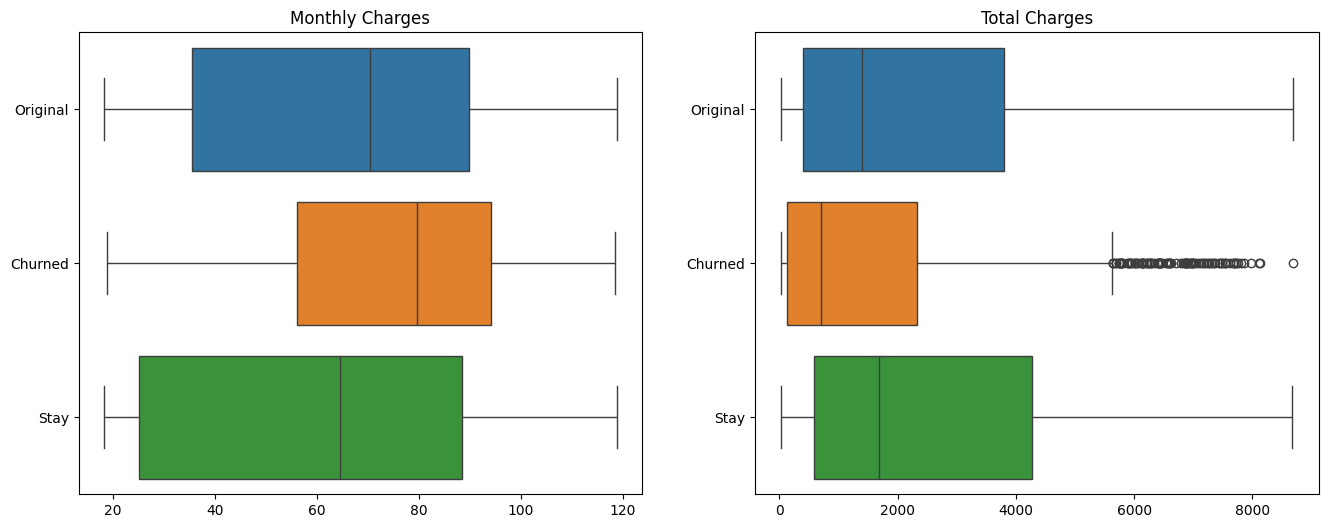

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(ax=axes[0], data=[list(original_mo), list(churned_mo), list(stay_mo)], orient='h')
axes[0].set_title('Monthly Charges')
axes[0].set_yticks([0, 1, 2])
axes[0].set_yticklabels(['Original', 'Churned', 'Stay'])

sns.boxplot(ax=axes[1], data=[list(original_total), list(churned_total), list(stay_total)], orient='h')
axes[1].set_title('Total Charges')
axes[1].set_yticks([0, 1, 2])
axes[1].set_yticklabels(['Original', 'Churned', 'Stay'])

plt.show()

#### `monthly_charges` 

Looking at the monthly charges between customers that churn and those that stay, I can see that the IQR for those that stay is significantly wider. 

* The monthly charge IQR range for churned customers is from $56-$94, with a median value of $79.
* The monthly charge IQR range for retained customers is from $25-$88 with a median value of $64.  

So this is telling me that the customers who are churning are paying more as a group. Could we do something to reduce the prices? Why are they all over the place for customers anyway?

#### `total_charges`

Looking at the overall charges for customers can be a tad tricky. I say that because a customer could stay for 1-2 months and their total charges will be significantly lower than someone that has been with the company for 5-6 years.

Which is honestly what we're seeing in the data:

* The total charge IQR range for churned customers IQR is $134-$2331, with a median of $703. 
* While the total charge IQR range for retained customers IQR is $577-$4264, with a median of $1683.



#### Analysis of Other Features

I want to look at the 3 dataframes (original, churned and stay) and compare each of the other features in comparison with those dataframes

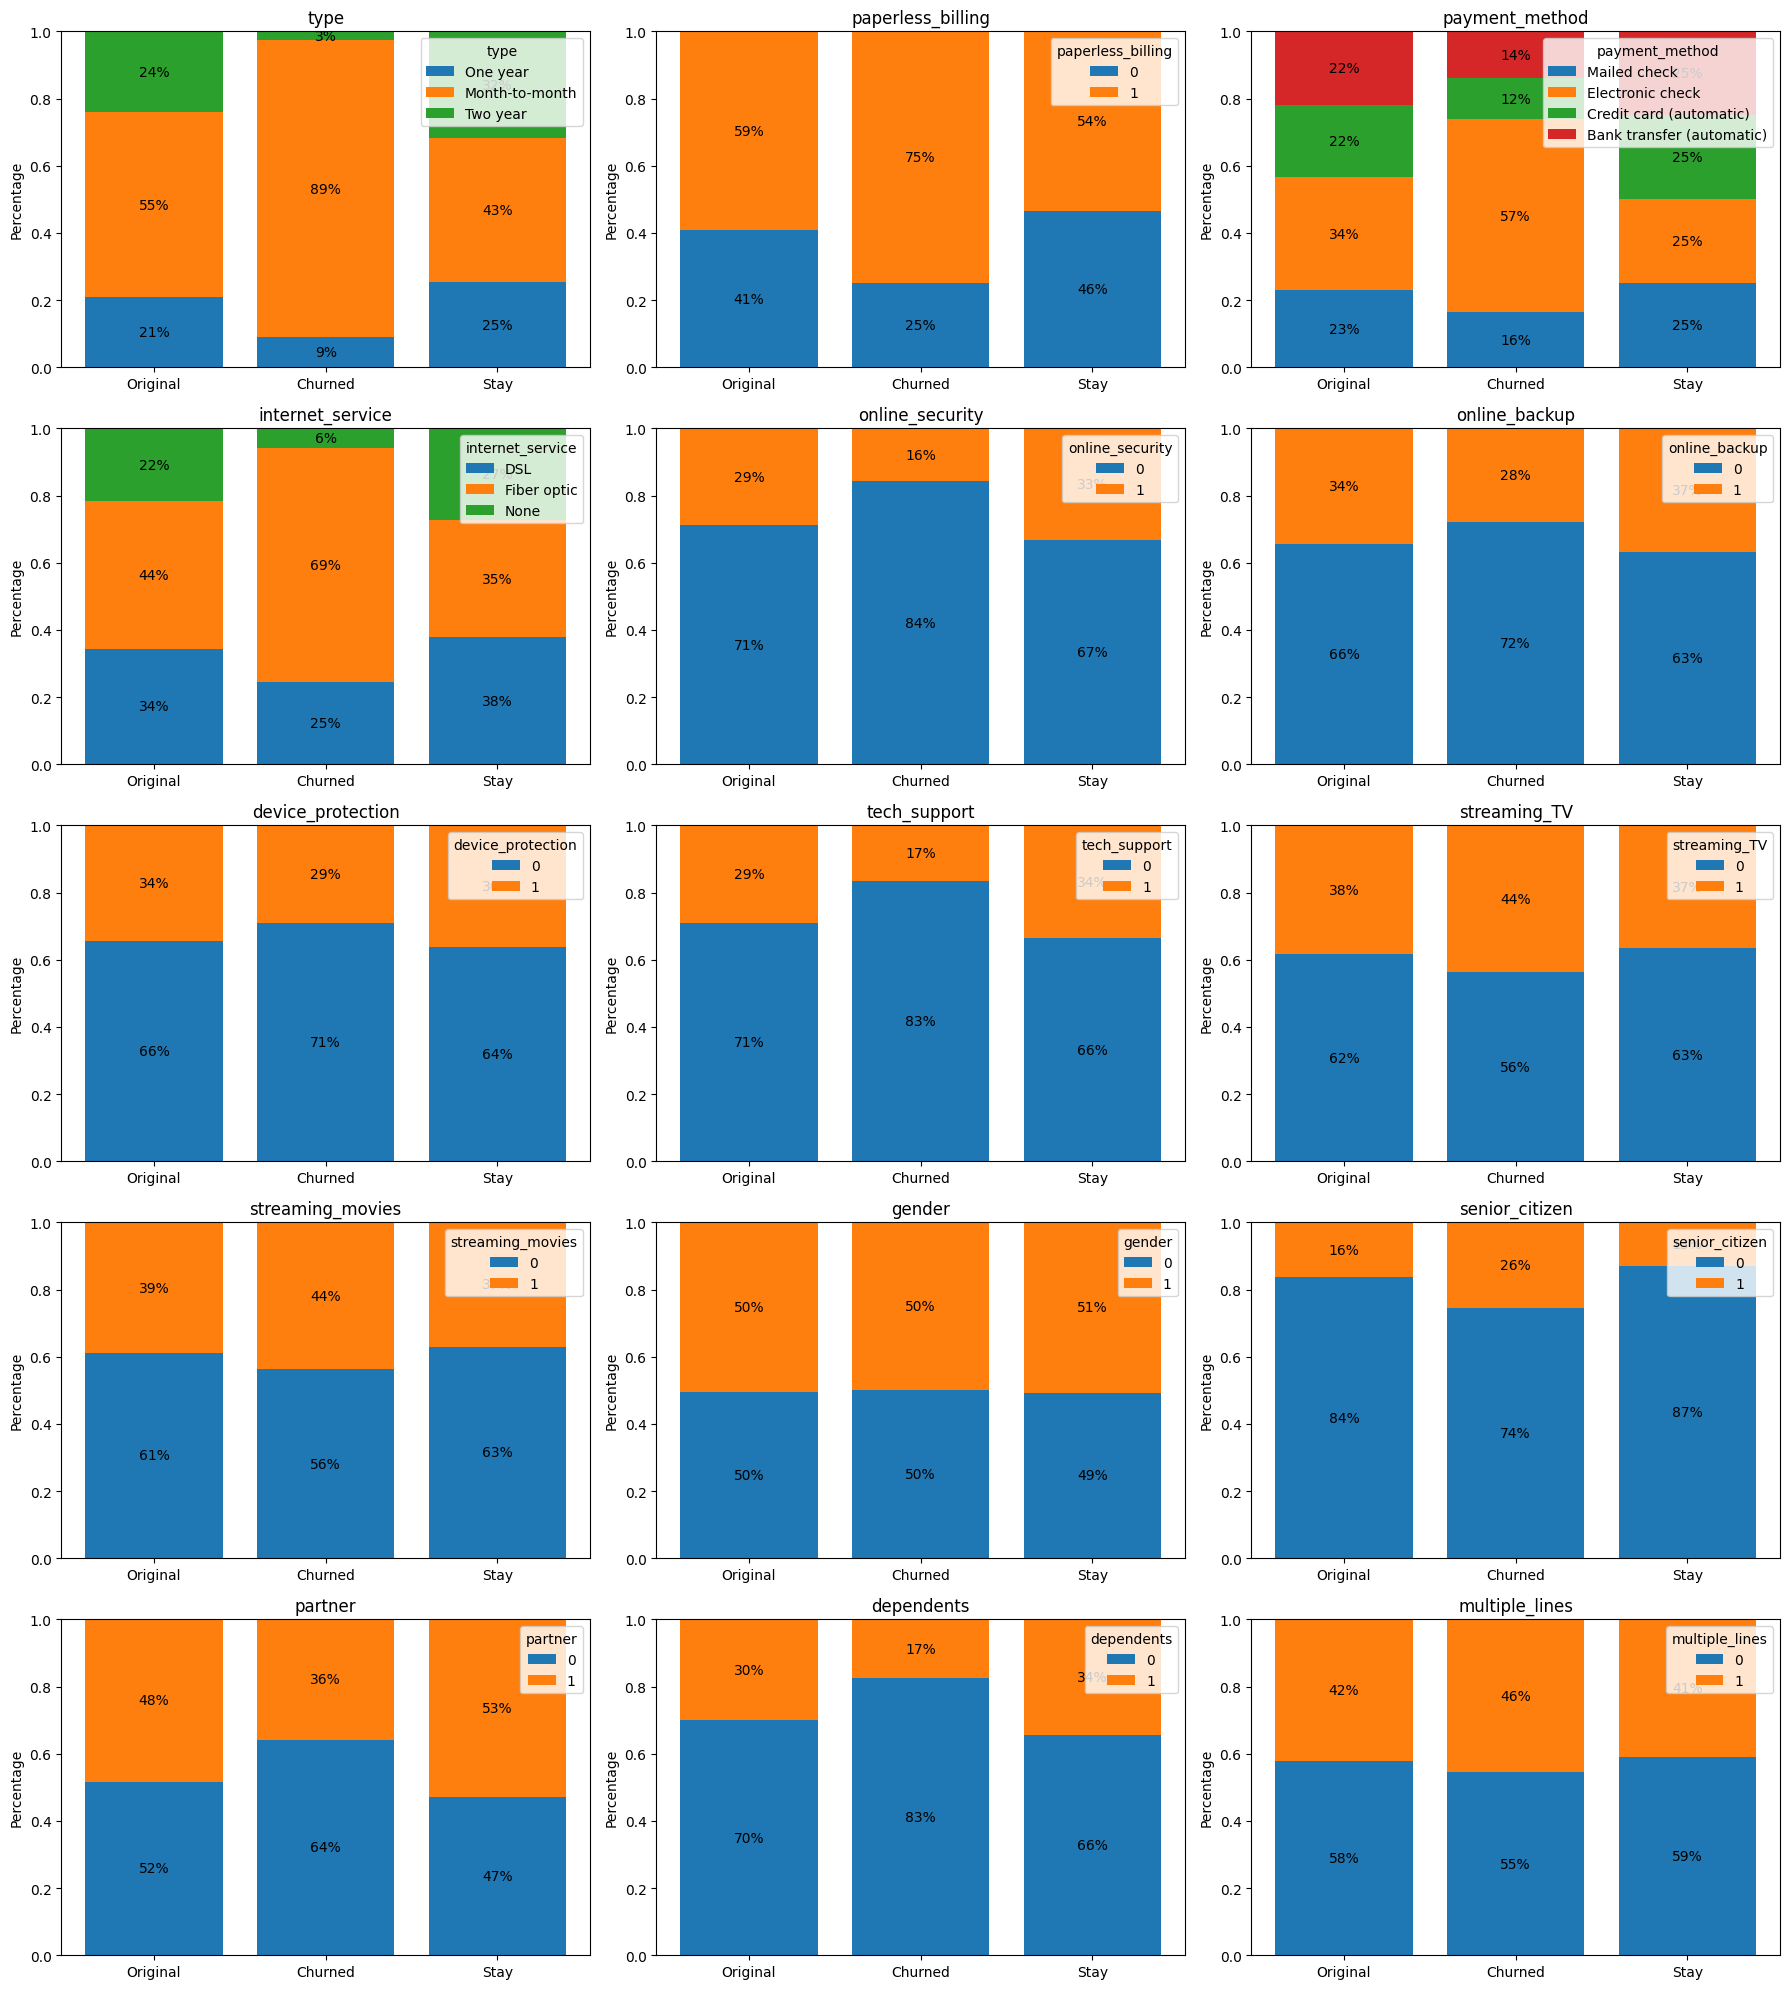

In [42]:
def create_stacked_bar(column, ax=None):
    dfs = [merged_df, churned_df, stay_df]
    dfs_names = ['Original', 'Churned', 'Stay']
    
    # Get all unique values for the column across all dataframes
    types = pd.concat([d[column] for d in dfs]).dropna().unique()

    # Define a color map for the unique values
    color_map = {
        0: '#1f77b4',
        1: '#ff7f0e'
    }
    
    # Create an empty DataFrame with those values as columns
    bar_df = pd.DataFrame(index=dfs_names, columns=types, dtype='float')


    for idx, d in enumerate(dfs):
        value = d[column].value_counts(normalize=True).reindex(types, fill_value=0).round(3)
        bar_df.loc[dfs_names[idx]] = value

    if set([0,1]).issubset(bar_df.columns):
        bar_df = bar_df[[0, 1]]

    if ax is None:
        fig, ax = plt.subplots()

    bottom = np.zeros(len(dfs))

    for k in bar_df.columns:
        ratios = bar_df[k].astype(float).values
        bars = ax.bar(dfs_names, ratios, label=str(k), bottom=bottom, color=color_map.get(k))
        # Add formatted labels inside bars
        ax.bar_label(bars, labels=[f'{r*100:.0f}%' if r > 0 else '' for r in ratios], label_type='center')
        bottom += ratios

    ax.set_title(column)
    ax.set_ylabel('Percentage')
    ax.set_ylim(0, 1)
    ax.legend(title=column, loc='upper right')

# Define feature lists
categorical_list = [
    'type', 'paperless_billing', 'payment_method', 'internet_service',
    'online_security', 'online_backup', 'device_protection', 'tech_support',
    'streaming_TV', 'streaming_movies', 'gender', 'senior_citizen',
    'partner', 'dependents', 'multiple_lines'
]

# Set up the grid for subplots
num_features = len(categorical_list)
num_cols = 3
num_rows = int(np.ceil(num_features / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
axes = axes.flatten()

# Generate the stacked bar charts
for i, column in enumerate(categorical_list):
    create_stacked_bar(column, ax=axes[i])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Breakdown of stacked bar chart

* `type`: this chart is telling me that the majority of the customers who have churned are month-to-month users. A very small amount are one or two year contracts. We should employ the company to get everyone into contracts if possible because month-to-month customers can leave at any time.
* `paperless_billing`: majority of the customers who have churned have paperless billing. I'm not sure how paperless billing factors into customer churn, but it's something we will throw into our ML model.
* `payment_method`: this one here is telling me that majority of the customers who churned use electronic checks as their payment method. Mail in checks is second. Should we encourage more credit card payments or bank transfers? Give an incentive for using those methods?
* `internet_service`: surprising enough, customers who have fiber optic internet service tend to churn more than DSL. Is our fiber optic service not up to par? Are they finding better fiber optic service providers?
* `online_security`: This is showing that those who have internet service but no online security are churning at a high rate, but the customers that we retain also don't have online security at a high rate.
* `online_backup`: I'm seeing here that about 70% of internet users without online backup are churning, but 60% of retained clients don't have it either.
* `device_protection`: Same goes for device protection.
* `tech_support`: Now with tech support we need to see how well this correlates with churn, because customers who feel they aren't getting adequate support might churn more than those that do. In this graphic for both churned and retained customers the majority don't have tech support, but I'd be interested to see the correlation.
* `streaming_TV`: Will be another feature to throw in the model to see how it turns out. It's hard to say just looking at this graphic.
* `streaming_movies`: Customers who churn stream slightly less movies, but customers we retain also stream less movies.
* `gender`: Gender is actually split about 50/50 for both churned and retained customers.
* `senior_citizen`: We have majority of our clients not be senior citizens with only about 25% of the customers that do churn end up being seniors.
* `partner`: Customers who have no partners churn and have churned do so at about a 64% rate. 
* `dependents`: Not having dependents looks as if it plays a big factor in churning. About 83% of the customers who have churned, don't have any dependents.
* `multiple_lines`: Multiple lines is about dead even for both churned and retained clients.


#### Looking at correlation between features

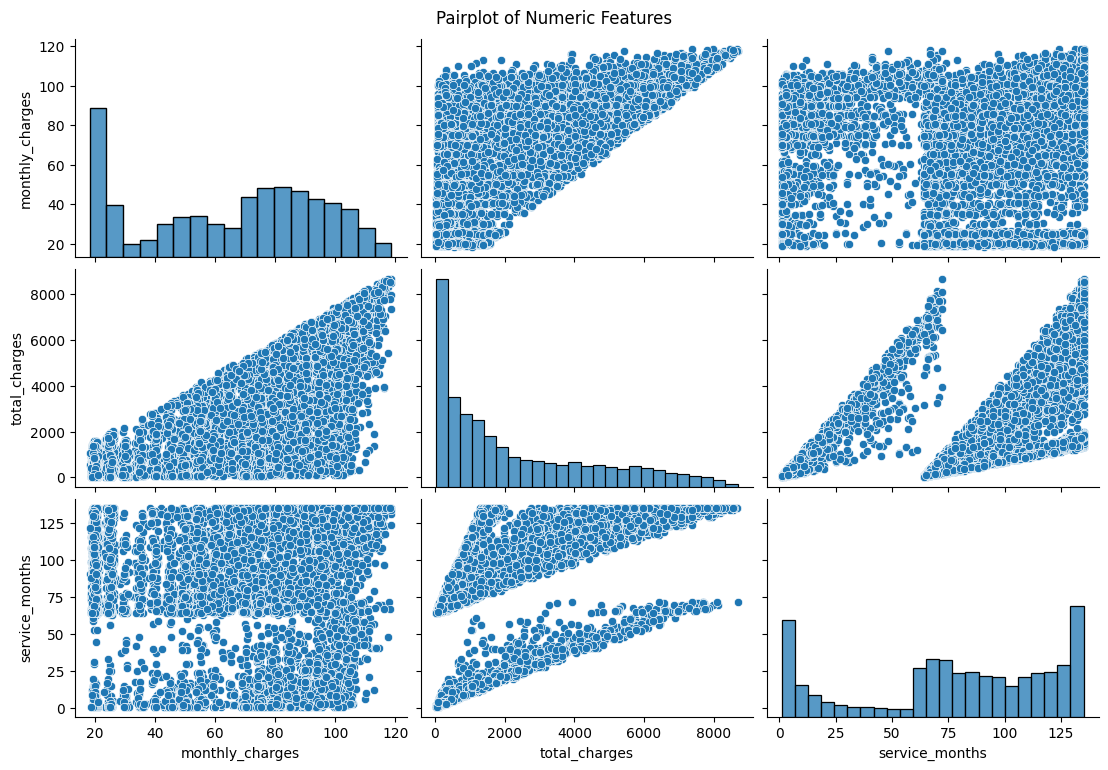

In [43]:
numeric_features = [
    'monthly_charges', 'total_charges', 'service_months'
]

sns.pairplot(merged_df[numeric_features], diag_kind="hist", height=2.5, aspect=1.5)
plt.suptitle('Pairplot of Numeric Features', y=1.02)
plt.show()

In [44]:
corr_charges = merged_df['total_charges'].corr(merged_df['monthly_charges'])
corr_months = merged_df['total_charges'].corr(merged_df['service_months'])
corr_months_charges = merged_df['monthly_charges'].corr(merged_df['service_months'])
print(f"Correlation between Total Charges and Monthly Charges: {corr_charges:.2f}")
print(f"Correlation between Total Charges and Service Months: {corr_months:.2f}")
print(f"Correlation between Monthly Charges and Service Months: {corr_months_charges:.2f}")

Correlation between Total Charges and Monthly Charges: 0.65
Correlation between Total Charges and Service Months: 0.60
Correlation between Monthly Charges and Service Months: 0.02


Looking at this graphic, it speaks to me intuitively. As the number of service months increases, total charges are going up. As monthly charges increases, total charges increases right along with it. And there's no real correlation between monthly charges and service months, however I do see that a concentration of customers around the $20/month range have been with the service a long time. And newer customers are concentrated more heavily around $70-$90 a month. 

This could hint to the fact that customers that were with the company years ago got in when prices were lower.

There's a positive correlation between `total_charges` and the other two features, although not as strong on `service_months`. I may still keep both charges even though they are slightly correlate. I don't think it's strong enough to drop one of them for my model.

#### Correlation between the other features

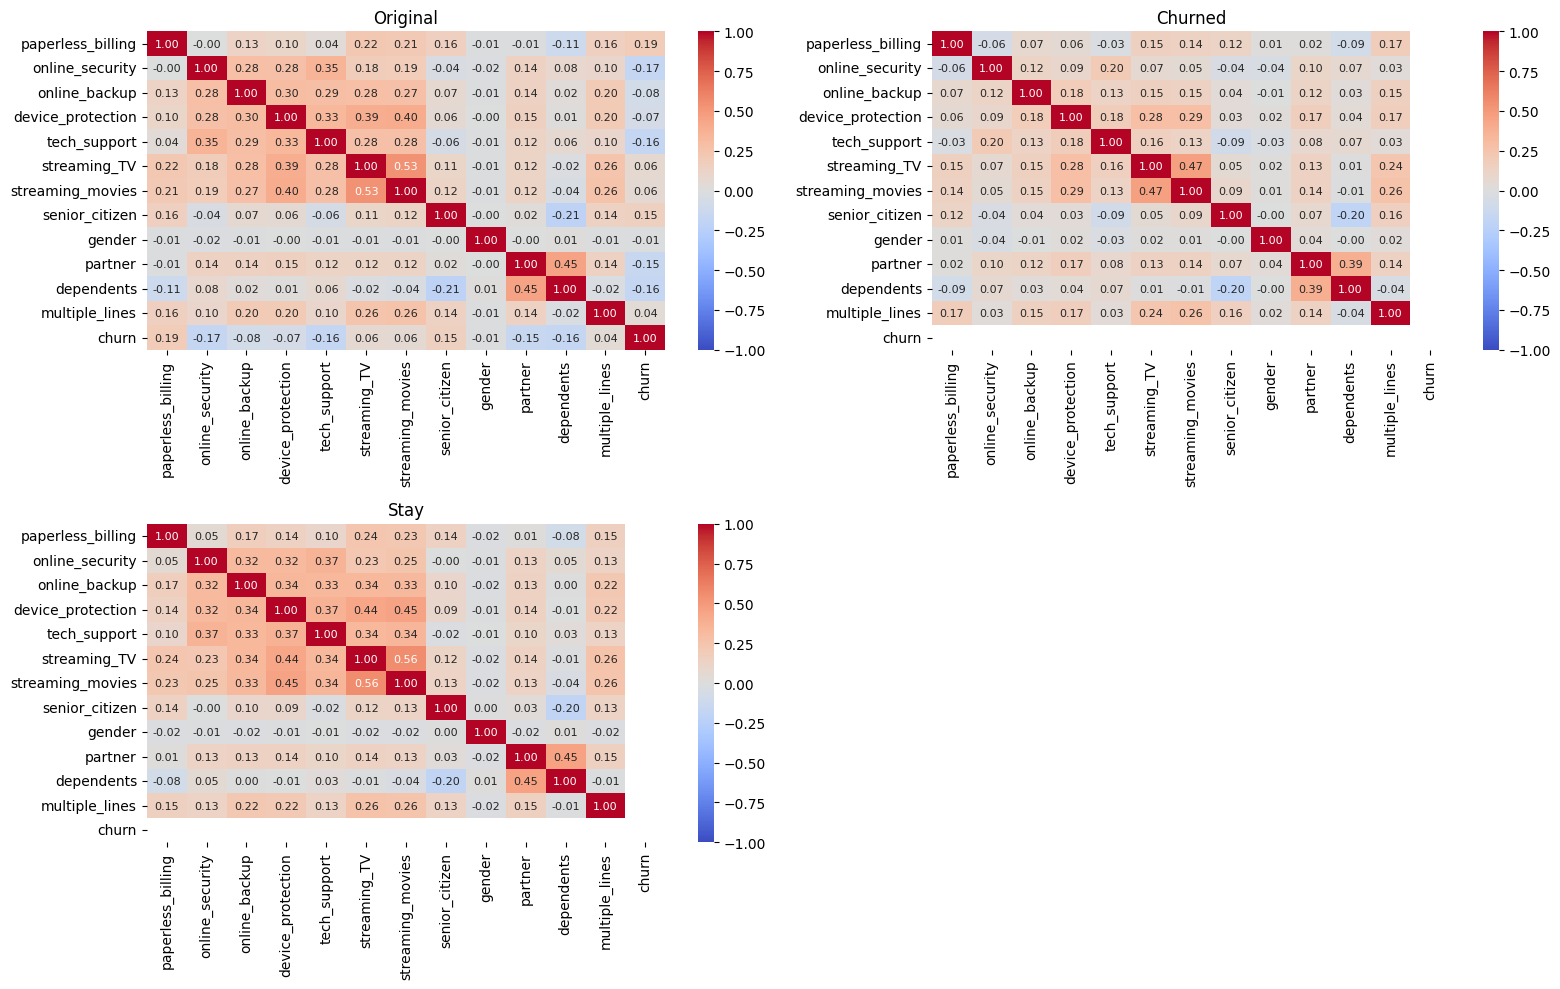

In [45]:
# Define the binary features list
binary_list = [
    'paperless_billing', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_TV',
    'streaming_movies', 'senior_citizen', 'gender', 'partner',
    'dependents', 'multiple_lines', 'churn'
]

def create_corr_heatmap_subplot(ax, df, title):
    # Just select the binary columns (assumed to be already 0/1)
    binary_df = df[binary_list].copy()

    # Drop any rows with NaN values just in case
    binary_df = binary_df.dropna()

    # Compute correlation matrix
    correlation_matrix = binary_df.corr()

    # Plot the heatmap
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        ax=ax,
        annot_kws={"size": 8},
        fmt=".2f"
    )
    ax.set_title(title)



# DataFrames to compare
dfs = [merged_df, churned_df, stay_df]
dfs_names = ['Original', 'Churned', 'Stay']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Create the plots
for idx, (data, name) in enumerate(zip(dfs, dfs_names)):
    create_corr_heatmap_subplot(axes[idx], data, name)

# Hide unused subplot if you have fewer than 4 plots
for i in range(len(dfs), 4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Looking at the heatmaps we can see that there aren't very many strong correlation (positive or negative) for the features. The strongest correlation is `streaming_TV` vs `streaming_movies` with it being only a 0.53 correlation. So I won't remove one of them for the training.

As stated previously, customers who tend to have a partner or dependents, I felt were less likely to `churn` which is somewhat verified here in the heatmap with the negative correlation.


# Feature Engineering

I created a `churn` column earlier and kept `end_date` since I believe it has pertinent information. I will use the `churn` column to run through my model.

I want to create a feature to display whether or not customers have internet and multiple phone lines. Also in this section, I will encode the categorical features, scale my data, remove redundant features (if any), and split the data into training, validation and test sets.

## Internet/Phone

In [46]:
merged_df['mult_services'] = ((merged_df['internet_service'] != 'None') & merged_df['multiple_lines'] == 1).astype(int)

In [47]:
merged_df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,churn,service_months,mult_services
0,0002-ORFBO,2019-05-01,2025-05-22,One year,1,Mailed check,65.60,593.30,DSL,0,1,0,1,1,0,0,0,1,1,0,0,72,0
1,0003-MKNFE,2019-05-01,2025-05-22,Month-to-month,0,Mailed check,59.90,542.40,DSL,0,0,0,0,0,1,1,0,0,0,1,0,72,1
2,0004-TLHLJ,2019-09-01,2020-01-01,Month-to-month,1,Electronic check,73.90,280.85,Fiber optic,0,0,1,0,0,0,1,0,0,0,0,1,4,0
3,0011-IGKFF,2018-12-01,2020-01-01,Month-to-month,1,Electronic check,98.00,1237.85,Fiber optic,0,1,1,0,1,1,1,1,1,0,0,1,13,0
4,0013-EXCHZ,2019-09-01,2019-12-01,Month-to-month,1,Mailed check,83.90,267.40,Fiber optic,0,0,0,1,1,0,0,1,1,0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,2019-01-01,2025-05-22,One year,0,Mailed check,55.15,742.90,DSL,1,0,0,1,0,0,0,0,0,0,0,0,76,0
7039,9992-RRAMN,2018-02-01,2019-12-01,Month-to-month,1,Electronic check,85.10,1873.70,Fiber optic,0,0,0,0,0,1,1,0,1,0,1,1,22,1
7040,9992-UJOEL,2019-12-01,2025-05-22,Month-to-month,1,Mailed check,50.30,92.75,DSL,0,1,0,0,0,0,1,0,0,0,0,0,65,0
7041,9993-LHIEB,2014-07-01,2025-05-22,Two year,0,Mailed check,67.85,4627.65,DSL,1,0,1,1,0,1,1,0,1,1,0,0,130,0


## Feature Selection

I'm creating a list of features to drop due to redundancy and/or them not being useful for my training.

In [48]:
drop_list = ['customer_id', 'end_date', 'total_charges', 'service_months']
merged_df.drop(drop_list, axis=1, inplace=True)

`customer_id`: just an id number and not useful for training

`end_date`: this was my original target. I've extracted the information from this column and created the `churn` column.

`total_charges`: this feature is similar to `monthly_charges`, since there multicollinearity between the two I decided to drop `total_charges`

`service_months`: this column was only used for analyzing. Having this column in my model will cause data leakage, the model will find the relationship between this and `begin_date`

## Converting `begin_date` to a number

In [49]:
# If I don't convert to a number, it will not work in my model
merged_df['begin_date'] = merged_df['begin_date'].dt.strftime('%Y%m').astype('int64') # only keeping year and month
merged_df['begin_date'] = merged_df['begin_date'] - 20000

## Encoding categorical features

I will be using One-Hot Encoding to encode `internet_services`, `payment_method` and `type`.

### One-Hot Encoding

In [50]:
categorical_list = ['internet_service', 'payment_method', 'type']
ohe_df = pd.get_dummies(merged_df, columns=categorical_list, drop_first=True)
ohe_df.reset_index(drop=True, inplace=True)
ohe_df.head()

,begin_date,paperless_billing,monthly_charges,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,churn,mult_services,internet_service_Fiber optic,internet_service_None,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,type_One year,type_Two year
0,181905,1,65.6,0,1,0,1,1,0,0,0,1,1,0,0,0,False,False,False,False,True,True,False
1,181905,0,59.9,0,0,0,0,0,1,1,0,0,0,1,0,1,False,False,False,False,True,False,False
2,181909,1,73.9,0,0,1,0,0,0,1,0,0,0,0,1,0,True,False,False,True,False,False,False
3,181812,1,98.0,0,1,1,0,1,1,1,1,1,0,0,1,0,True,False,False,True,False,False,False
4,181909,1,83.9,0,0,0,1,1,0,0,1,1,0,0,1,0,True,False,False,False,True,False,False


### Oversampling via SMOTE

Earlier we discussed that the data is imbalanced. We will use SMOTE to oversample the minority class (churned customers) to balance the dataset.

In [51]:
def apply_smote(data, target_col, train_size=0.3, random_state=42):
    X = data.drop(target_col, axis=1)
    y = data[target_col]

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=train_size, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)

    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    columns = X.columns
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns)

    return X_train_scaled, y_train_balanced, X_val_scaled, y_val, X_test_scaled, y_test


In [52]:
ohe_X_train, ohe_y_train, ohe_X_val, ohe_y_val, ohe_X_test, ohe_y_test = apply_smote(ohe_df, 'churn')


### Creating a pipeline

In [53]:
def train_pipeline(model_name, model, X_train, X_val, y_train, y_val):
    start = time.time()
    if model_name == 'CatBoost':
        model.fit(X_train, y_train, verbose=200)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    time_consumed = round((time.time() - start), 3)
    return roc_auc, time_consumed

In [54]:
log_reg = LogisticRegression(random_state=42)
dt_defaut = DecisionTreeClassifier(random_state=42)
rf_default = RandomForestClassifier(random_state=42)
xgb_default = XGBClassifier(random_state=42)
lgbm_default = LGBMClassifier(random_state=42)
cb_default = CatBoostClassifier(random_state=42)

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
model_list = [log_reg, dt_defaut, rf_default, xgb_default, lgbm_default, cb_default]

time_consumed_list = []
auc_list = []

for idx, model_obj in enumerate(model_list):
    model_name = model_names[idx]
    roc_auc, time_consumed = train_pipeline(model_name, model_obj, ohe_X_train, ohe_X_val, ohe_y_train, ohe_y_val)

    auc_list.append(roc_auc)
    time_consumed_list.append(time_consumed)


results_df = pd.DataFrame({
    'Model': model_names,
    'ROC AUC': auc_list,
    'Time Consumed (s)': time_consumed_list
})

results_df = results_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)

results_df


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Learning rate set to 0.023996
0:	learn: 0.6797385	total: 61.3ms	remaining: 1m 1s
200:	learn: 0.3479561	total: 445ms	remaining: 1.77s
400:	learn: 0.3104100	total: 835ms	remaining: 1.25s
600:	learn: 0.2816513	total: 1.22s	remaining: 810ms
800:	learn: 0.2593231	total: 1.61s	remaining: 400ms
999:	learn: 0.2412192	total: 1.99s	remaining: 0us


,Model,ROC AUC,Time Consumed (s)
0,LightGBM,0.838924,0.186
1,CatBoost,0.833436,2.053
2,XGBoost,0.817445,0.117
3,Random Forest,0.812514,0.408
4,Logistic Regression,0.797312,0.017
5,Decision Tree,0.676270,0.024


Looking at the results above, we have the ROC-AUC for the different models and their default settings.

The top 3 scores are 'LightGBM', 'CatBoost', and 'XGBoost' with scores between 81-83. 

I also decided to time the models, so the 3 fastest models were 'Decision Tree', 'Logistic Regression' and 'XGBoost'.

### Fine tuning to find the best parameters

I'm going to use `RandomizedSearchCV` to find the best hyperparameters for each model.

In [55]:
def random_optimize(model_name, estimator, param_grid, X_train, y_train, n_iter, cv):
    print(f"Start searching parameters for {model_name}...")
    start = time.time()
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring='roc_auc',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    if model_name == 'CatBoost':
        random_search.fit(X_train, y_train, verbose=200)
    else:
        random_search.fit(X_train, y_train)
    print(f"Best paramaters: ", random_search.best_params_)
    print("Best Score: ", random_search.best_score_)
    print(f"The time consumed for {model_name} is: ", round((time.time() - start), 3), "s")
    print("--------------------------------------------")
    return random_search.best_params_


In [56]:
param_grid_lgr = {'C': [0.03, 0.1, 0.3, 1],'penalty': ['l2'],'solver': ['newton-cg', 'sag'], 'max_iter': [5000, 10000,20000], 'tol': [3e-4, 1e-4, 3e-5], 'warm_start': [True, False]}
param_grid_dtc = {'max_depth': [6, 9, 12], 'min_samples_split': [2, 4, 5, 8, 10], 'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy'],'splitter': ['best', 'random']}
param_grid_rfr = {'n_estimators': [50, 100, 200],'max_depth': [None, 5, 10],'min_samples_split': [4, 8, 16],'min_samples_leaf': [1, 2, 4, 8]}
param_grid_xgb = {'n_estimators': [200, 300, 400],'learning_rate': [0.05, 0.1, 0.3],'max_depth': [6, 9, 12], 'subsample': [0.9, 1.0, 1,1], 'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.01, 0.05], 'reg_lambda': [0.0, 0.01, 0.05]}
param_grid_lgb= {'learning_rate': [0.01,0.03, 0.05,0.1, 0.3], 'n_estimators': [100,300, 500,700, 1000], 'subsample': [0.8, 0.9, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0],'reg_alpha': [0, 0.003, 0.01], 'reg_lambda': [0, 0.003, 0.01]}
param_grid_cat = {'learning_rate': [0.01, 0.1, 0.2, 0.4], 'n_estimators': [100, 1000, 5000, 10000], 'depth': [3, 6, 9, 12], 'l2_leaf_reg': [1e-4, 3e-4, 1e-3, 3e-3], 'min_child_samples': [50, 100, 150], 'subsample': [0.8, 0.9, 1.0]}

params_list = [param_grid_lgr, param_grid_dtc, param_grid_rfr, param_grid_xgb, param_grid_lgb, param_grid_cat]
best_params_list = []
for idx, param_grid in enumerate(params_list):
    model_name = model_names[idx]
    if model_name == 'CatBoost':
        best_params = {'subsample': 0.8, 'n_estimators': 5000, 'min_child_samples': 150, 'learning_rate': 0.01, 'l2_leaf_reg': 0.003, 'depth': 12}
    else:
        best_params = random_optimize(model_names[idx], model_list[idx], param_grid, ohe_X_train, ohe_y_train, n_iter=10, cv=5)
    
    best_params_list.append(best_params)


Start searching parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best paramaters:  {'warm_start': True, 'tol': 0.0003, 'solver': 'sag', 'penalty': 'l2', 'max_iter': 20000, 'C': 0.1}
Best Score:  0.8785717279481806
The time consumed for Logistic Regression is:  2.191 s
--------------------------------------------
Start searching parameters for Decision Tree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best paramaters:  {'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 9, 'criterion': 'entropy'}
Best Score:  0.8777515564658988
The time consumed for Decision Tree is:  0.255 s
--------------------------------------------
Start searching parameters for Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best paramaters:  {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': None}
Best Score:  0.9234139378297787
The time consumed for Rand

In [57]:
len(best_params_list)

6

Now the best hyperparameters of these 6 models are stored in `best_params_list`

In [58]:
results_df

,Model,ROC AUC,Time Consumed (s)
0,LightGBM,0.838924,0.186
1,CatBoost,0.833436,2.053
2,XGBoost,0.817445,0.117
3,Random Forest,0.812514,0.408
4,Logistic Regression,0.797312,0.017
5,Decision Tree,0.676270,0.024


In [59]:
log_reg_opt = LogisticRegression(random_state=42, **best_params_list[0])
dtc_opt = DecisionTreeClassifier(random_state=42, **best_params_list[1])
rfc_opt = RandomForestClassifier(random_state=42, **best_params_list[2])
xgb_opt = XGBClassifier(random_state=42, **best_params_list[3])
lgb_opt = LGBMClassifier(random_state=42, **best_params_list[4])
cat_opt = CatBoostClassifier(random_state=42, **best_params_list[5])
opt_model_list = [log_reg_opt, dtc_opt, rfc_opt, xgb_opt, lgb_opt, cat_opt]

time_consume_list = []
auc_list = []

for idx, model_obj in enumerate(opt_model_list):
    model_name = model_names[idx]
    roc_auc, time_consume = train_pipeline(model_name, model_obj, ohe_X_train, ohe_X_val, ohe_y_train, ohe_y_val)

    auc_list.append(roc_auc)
    time_consume_list.append(time_consume)

results_df['optimized ROC AUC'] = auc_list
results_df['ROC AUC difference'] = results_df['optimized ROC AUC'] - results_df['ROC AUC']

results_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.6785960	total: 46.7ms	remaining: 3m 53s
200:	learn: 0.1675271	total: 7.31s	remaining: 2m 54s
400:	learn: 0.0979697	total: 14.2s	remaining: 2m 43s
600:	learn: 0.0680691	total: 20.8s	remaining: 2m 32s
800:	learn: 0.0494283	total: 27.3s	remaining: 2m 23s
1000:	learn: 0.0339937	total: 34.6s	remaining: 2m 18s
1200:	learn: 0.0235835	total: 42s	remaining: 2m 12s
1400:	learn: 0.0163955	total: 49.5s	remaining: 2m 7

,Model,ROC AUC,Time Consumed (s),optimized ROC AUC,ROC AUC difference
0,LightGBM,0.838924,0.186,0.799130,-0.039794
1,CatBoost,0.833436,2.053,0.783316,-0.050120
2,XGBoost,0.817445,0.117,0.827315,0.009870
3,Random Forest,0.812514,0.408,0.826749,0.014235
4,Logistic Regression,0.797312,0.017,0.824351,0.027039
5,Decision Tree,0.676270,0.024,0.803093,0.126823


After performing hyperparameter fine tuning, I got an optimized list of ROC AUC scores. Comparing it to the previous scores of the default models, 'XGBoost', 'Random Forest', 'Logistic Regression', and 'Decision Tree' models all scored slightly better.

Overall, the top 3 highest scores are 'LightGBM', 'CatBoost' and 'Optimized XGBoost'. 

Since 'LightGBM' had the highest scoring, I will be using that model to check the score of the test set.

# Testing

I will try out my model on test set and calculate the ROC AUC scores on that.

In [60]:
model = LGBMClassifier(random_state=42)
model.fit(ohe_X_train, ohe_y_train)
y_pred = model.predict(ohe_X_test)
y_pred_proba = model.predict_proba(ohe_X_test)[:, 1]
roc_auc = roc_auc_score(ohe_y_test, y_pred_proba)
print()
print(f"The final score on the test set is: {roc_auc:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

The final score on the test set is: 0.83


# Conclusion

In this project, the quality of data was pretty good. I didn't have to do much cleaning to the data and it was only when I combined all 4 dataframes that I had missing values. 

The target `churn` was imbalanced, so I applied a SMOTE technique (which is just oversampling) to balance out the data. 

Some things I found out during EDA:

* All of the churned data seemed to be in the last 4 months (Oct 2019 - Jan 2020).
* The IQR of the `monthly_charges` from the churned customers is higher than those that stay.
* Looking at the `type` column, most of the churned customers (89%) are month-to-month customers.
* Only 26% of the churned customers use automatic payments, while 50% of the customers who stay use automatic payments.

One thing that I brought up was `total_months` and `service_months`, due to the multicollinearity of the two along with `monthly_charges`, I decided to drop these two to prevent data leakage. I also dropped `customer_id` and `end_date`. Customer_id was deemed useless for my model, end_date we had already extracted the information and created the `churn` column.

I transformed all of binary data that was 'Yes/No' into 1's and 0's. And for the columns 'internet_service', 'payment_method' and 'type', I encoded using One-Hot Encoding. After encoding and scaling the data, I applied 6 classification models with their default settings to the training data.

During the fine tuning portion, I introduced `RandomizedSearchCV` to look for the best parameters. I listed a lot of hyperparameters, so some of the models took awhile to run. After my searching session, I found the best hyperparameters for each model and then applied them to the test set. Not all fine tuned models performed better. 


I chose the best model which was the default LightGBM and obtained a **ROC AUC score of: 0.83**.



#### Ideas for improvement

* Since `RandomizedSearchCV` combines hyperparameter groups at random for faster searching speed, it might skip good combinations. So for future testing, it would be beneficial to use `GridSearchCV`, especially for those models that got worse after tuning.

#### Feature Importance

It would also be beneficial to look at feature importance so I will do so now.

In [61]:
important_features = model.feature_importances_
feature_names = ohe_X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': important_features
}).sort_values(by='Importance', ascending=False)

encoded_cols = ['internet_service', 'payment_method', 'type']
encoded_feature_names = ohe_X_train.columns.tolist()

def get_original_feature(col, original_groups):
    for base in original_groups:
        if col.startswith(base + '_'):
            return base
    return col

feature_importance_df['base_feature'] = feature_importance_df['Feature'].apply(lambda x: get_original_feature(x, encoded_cols))

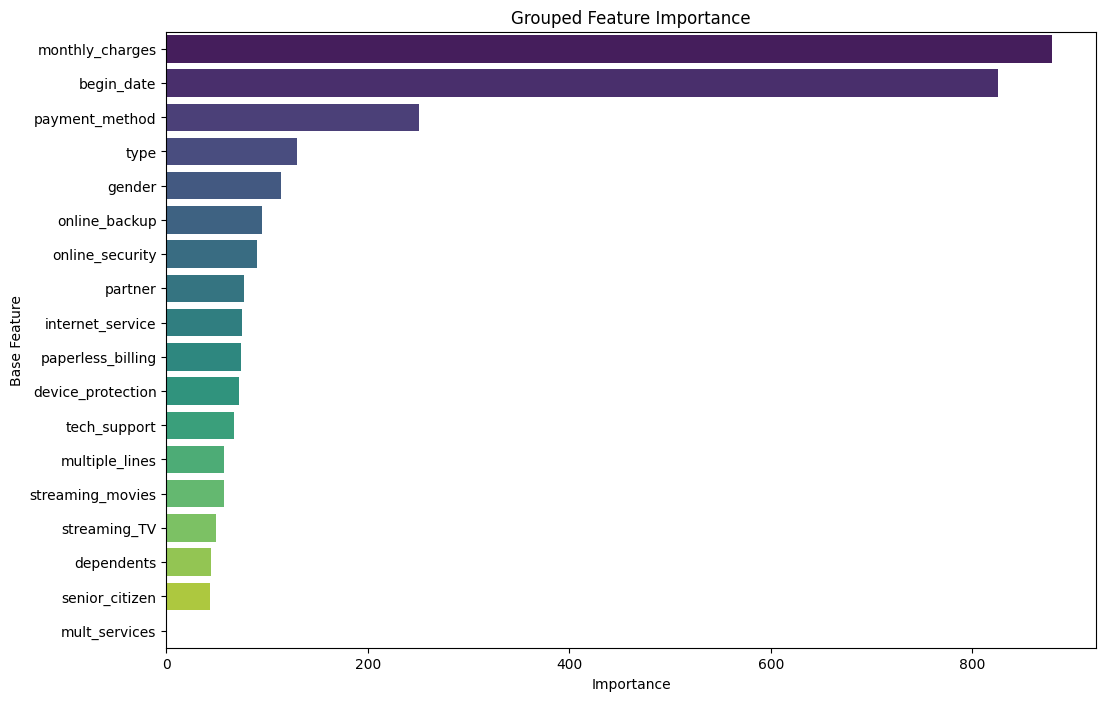

In [62]:
grouped_importance = feature_importance_df.groupby('base_feature')['Importance'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='base_feature', hue='base_feature', data=grouped_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Grouped Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Base Feature')
plt.show()

## Precision/Recall/PR Curve

Precision and Recall at Different Thresholds:
----------------------------------------
Threshold: 0.5
Precision: 0.55, Recall: 0.62, F1 Score: 0.58
Threshold: 0.4
Precision: 0.53, Recall: 0.71, F1 Score: 0.61
Threshold: 0.3
Precision: 0.51, Recall: 0.80, F1 Score: 0.62
Threshold: 0.2
Precision: 0.47, Recall: 0.88, F1 Score: 0.61
Threshold: 0.1
Precision: 0.41, Recall: 0.94, F1 Score: 0.57
----------------------------------------
Classifaction Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       776
           1       0.55      0.62      0.58       281

    accuracy                           0.77      1057
   macro avg       0.70      0.72      0.71      1057
weighted avg       0.78      0.77      0.77      1057



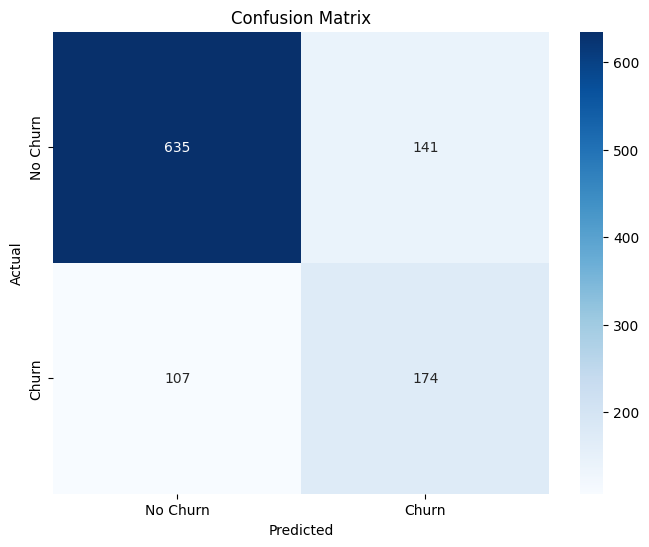

In [63]:

y_pred_prob = lgbm_default.predict_proba(ohe_X_test)[:, 1]

thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]

print("Precision and Recall at Different Thresholds:")
print("-" * 40)
for t in thresholds:
    y_rped_thresh = (y_pred_prob >= t).astype(int)
    precision = precision_score(ohe_y_test, y_rped_thresh)
    recall = recall_score(ohe_y_test, y_rped_thresh)
    f1 = f1_score(ohe_y_test, y_rped_thresh)
    print(f"Threshold: {t}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
print("-" * 40)

y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classifaction Report (Threshold = 0.5):")
print(classification_report(ohe_y_test, y_pred))

cm = confusion_matrix(ohe_y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
    

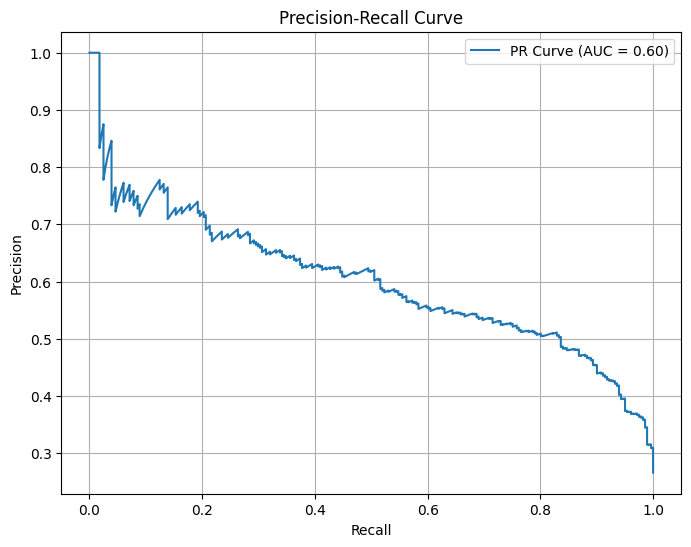

In [64]:
precision_vals, recall_vals, threshold_vals = precision_recall_curve(ohe_y_test, y_pred_prob)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

In the above matrix, I calculated precision and recall since the accuracy is misleading due to imbalance. 

Due to the class imbalance in the target variable, I chose not to rely on accuracy alone, as it can be misleading. Instead, I focused on precision and recall, which provide a clearer picture of how well the model identifies true churners.

From a business perspective, I believe Interconnect would be more concerned with missing actual churners (false negatives) than incorrectly flagging loyal customers (false positives). With that in mind, I prioritized recall and adjusted the decision threshold to 0.1 to maximize the model's ability to catch churners.

At this threshold, the model achieves a recall of 0.94, meaning it correctly identifies 94% of all churners. This would allow Interconnect to proactively reach out to at-risk customers with promotional offers or loyalty incentives to reduce churn.

The trade-off is a lower precision of 0.41, indicating that some customers flagged as churners may not actually be planning to leave. However, in this context, the cost of retaining a loyal customer unnecessarily is far lower than the cost of losing a paying customer.

Given Interconnect’s current churn challenges, the immediate goal should be to retain as many customers as possible, even if that means accepting some false positives. Once the churn rate stabilizes, they can revisit the threshold and optimize for a better balance between recall and precision.